# Final Project KIA - szenthen

## Problemstatement
#### End Users
This project is designed for radiologists, neurosurgeons, and medical research teams working on the diagnosis and treatment of brain tumors.

#### Goal of End Users
The primary goal of end users is to quickly and accurately classify brain tumors. This will improve diagnosis, develop personalized treatment plans, and enhance patient prognosis.

#### Obstacle to be Solved
The current manual analysis and classification of brain tumors is simply too time-consuming and prone to errors. This is leading to delayed diagnoses and potentially suboptimal treatment outcomes. Furthermore, the medical field is facing a shortage of skilled professionals, which is further exacerbating the challenges of timely and accurate diagnosis. An automated and accurate classification system will address these challenges by significantly increasing the efficiency and accuracy of the diagnostic processes, thus alleviating some of the burdens on the existing medical workforce.

## Imports

In [6]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Data collection and augmentation
The dataset used in this project can be found on Kaggle: https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset. The dataset contains 21,672 images, categorised into the following: "No Tumor", "Glioma", "Meningioma" and "Pituitary".

The dataset had already been augmented with the following techniques:
- Salt and Pepper Noise: Introducing random noise by setting pixels to white or black based on a specified intensity.
- Histogram Equalization: Applying histogram equalization to enhance the contrast and details in the images.
- Rotation: Rotating the images clockwise or counterclockwise by a specified angle.
- Brightness Adjustment: Modifying the brightness of the images by adding or subtracting intensity values.
- Horizontal and Vertical Flipping: Flipping the images horizontally or vertically to create mirror images.

It is counterproductive to distort brain MRI images for a classification model because it alters critical anatomical structures and diagnostic details essential for accurate tumor identification. This reduces the model's clinical relevance and effectiveness. It is crucial to maintain the integrity of the original images to ensure the model is trained on realistic and diagnostically useful data.
Therefore the augmentations include randomly zooming into the images by up to 10% and adjusting their contrast by up to 10% to enhance the robustness and generalization of the model.

In [7]:
from tensorflow.keras.layers import RandomZoom, RandomContrast
from tensorflow.keras.preprocessing import image_dataset_from_directory

def load_data(image_size=(224, 224), batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        'Brain',
        image_size=image_size,
        batch_size=batch_size,
        label_mode='categorical',
        seed=123
    )
    
    # Berechne die Anzahl der Bilder
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    test_size = int(0.1 * dataset_size)
    val_size = int(0.15 * dataset_size)
    train_size = dataset_size - val_size - test_size
    
    # Aufteilen des Datensatzes
    test_ds = dataset.take(test_size)
    remaining = dataset.skip(test_size)
    val_ds = remaining.take(val_size)
    train_ds = remaining.skip(val_size)
    
    return train_ds, val_ds, test_ds, dataset.class_names

def augment_data(dataset):
    data_augmentation = tf.keras.Sequential([
        RandomZoom(0.1),
        RandomContrast(0.1),
    ])
    
    def augment(image, label):
        image = tf.image.convert_image_dtype(image, tf.float32)
        return data_augmentation(image), label
    
    return dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

train_ds, val_ds, test_ds, class_names = load_data()

# Datenaugmentation nur auf den Trainingsdatensatz anwenden
train_ds = augment_data(train_ds)

# Berechnung der Anzahl der Bilder in jedem Datensatz
train_count = tf.data.experimental.cardinality(train_ds).numpy()
val_count = tf.data.experimental.cardinality(val_ds).numpy()
test_count = tf.data.experimental.cardinality(test_ds).numpy()

print(f"Trainingsbilder: {train_count*32}")
print(f"Validierungsbilder: {val_count*32}")
print(f"Testbilder: {test_count*32}")

print(f"Trainingsbatch: {train_count}")
print(f"Validierungsbatch: {val_count}")
print(f"Testbatch: {test_count}")
print(class_names)

Found 21672 files belonging to 4 classes.
Trainingsbilder: 16320
Validierungsbilder: 3232
Testbilder: 2144
Trainingsbatch: 510
Validierungsbatch: 101
Testbatch: 67
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Random images from the training set


2024-05-30 19:05:00.738763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


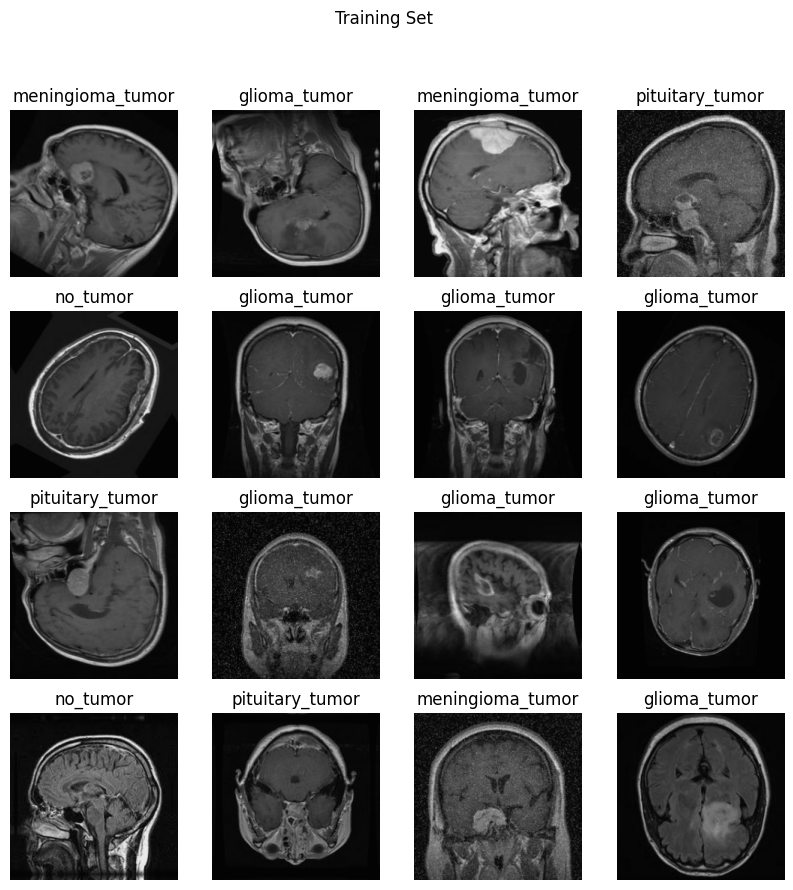

Random images from the validation set


2024-05-30 19:05:01.289666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


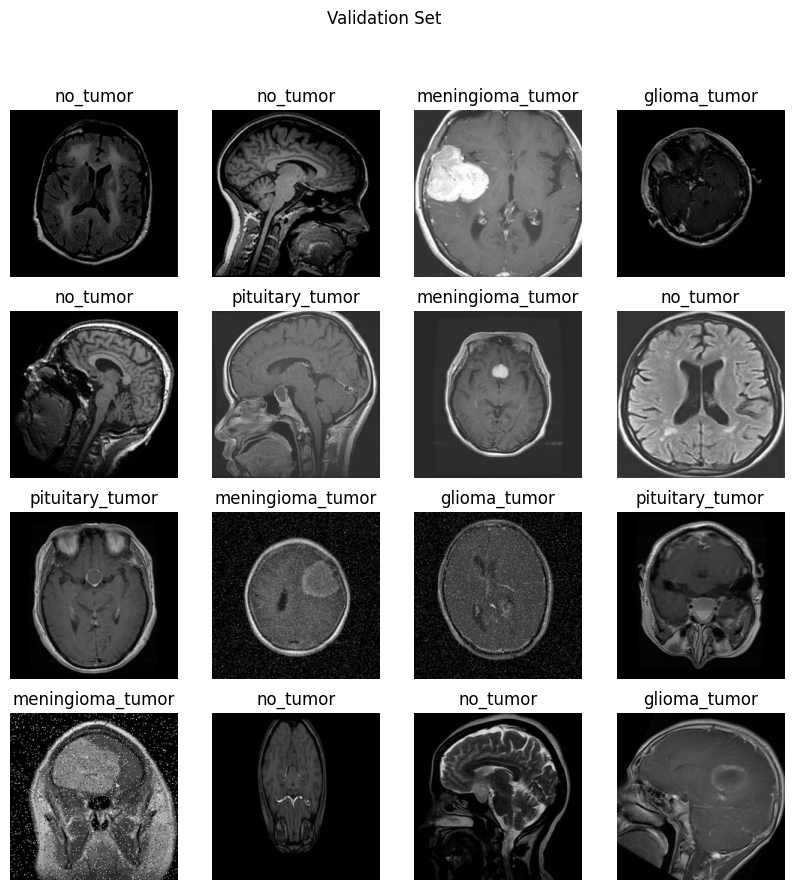

Random images from the test set


2024-05-30 19:05:01.784110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


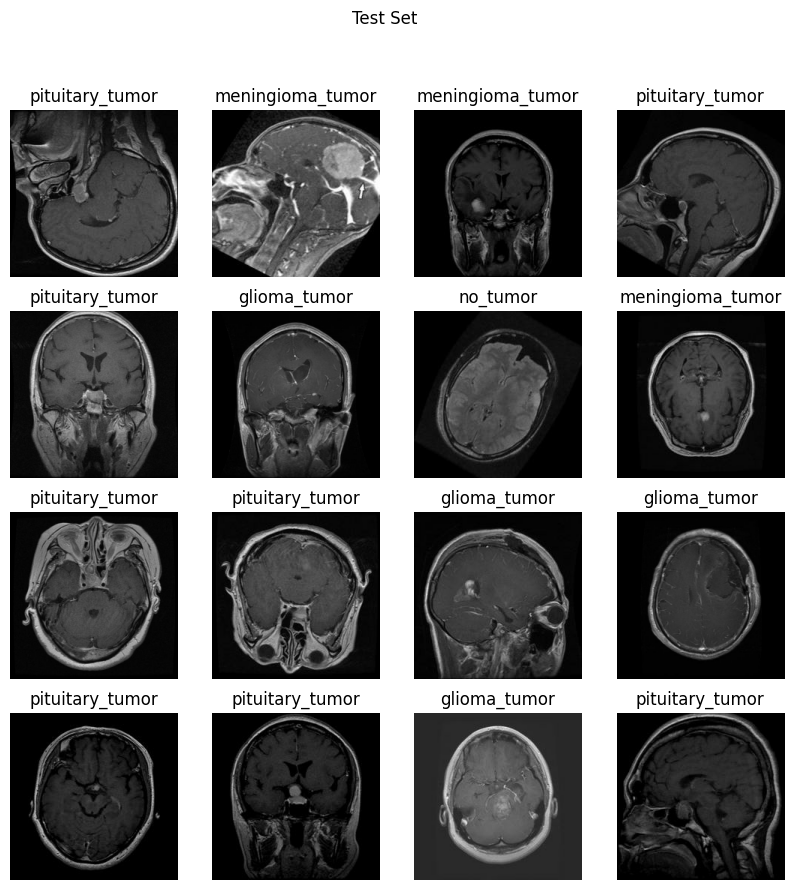

In [8]:
def show_random_images(dataset, class_names, title):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = class_names[np.argmax(labels[i])]
            plt.title(label)
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

print("Random images from the training set")
show_random_images(train_ds, class_names, "Training Set")
print("Random images from the validation set")
show_random_images(val_ds, class_names, "Validation Set")
print("Random images from the test set")
show_random_images(test_ds, class_names, "Test Set")

## Create Model

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def create_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255, offset=-1)(inputs)
    
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x) 
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Verwendung von 224x224 Bildgröße für ResNet50
model = create_model((224, 224, 3), len(class_names))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy', 'recall', 'precision'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_brain_classification.keras', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

base_epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=base_epochs, callbacks=callbacks)

Epoch 1/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - accuracy: 0.6835 - loss: 0.8001 - precision: 0.7471 - recall: 0.5987 - val_accuracy: 0.8648 - val_loss: 0.3508 - val_precision: 0.8812 - val_recall: 0.8465 - learning_rate: 0.0010
Epoch 2/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 776s 2s/step - accuracy: 0.8384 - loss: 0.4320 - precision: 0.8607 - recall: 0.8129 - val_accuracy: 0.8648 - val_loss: 0.3417 - val_precision: 0.8748 - val_recall: 0.8478 - learning_rate: 0.0010
Epoch 3/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.8788 - loss: 0.3317 - precision: 0.8933 - recall: 0.8623 - val_accuracy: 0.9004 - val_loss: 0.2639 - val_precision: 0.9064 - val_recall: 0.8926 - learning_rate: 0.0010
Epoch 4/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - accuracy: 0.8979 - loss: 0.2748 - precision: 0.9084 - recall: 0.8866 - val_accuracy: 0.8957 - val_loss: 0.2708 - val_precision: 0.9003 - val_recall: 0.8883 - learning_rate: 0.0010
Epoch 5/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 914s 2s/step - accur

In [10]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print("Test dataset evaluation")
results = model.evaluate(test_ds)
print(f"Loss: {results[0]}, Accuracy: {results[1]}")

# Get the true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

# Calculate accuracy, precision, recall, and f1-score
accuracy = accuracy_score(y_true, y_pred)

precision_micro_base = precision_score(y_true, y_pred, average='micro')
recall_micro_base = recall_score(y_true, y_pred, average='micro')
f1_micro_base = f1_score(y_true, y_pred, average='micro')

precision_macro_base = precision_score(y_true, y_pred, average='macro')
recall_macro_base = recall_score(y_true, y_pred, average='macro')
f1_macro_base = f1_score(y_true, y_pred, average='macro')

# Detailed classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

Test dataset evaluation
67/67 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9423 - loss: 0.1657 - precision: 0.9431 - recall: 0.9410
Loss: 0.18373322486877441, Accuracy: 0.9305037260055542
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━

2024-05-30 21:28:23.260159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
print(f"Micro Precision: {precision_micro_base}")
print(f"Micro Recall: {recall_micro_base}")
print(f"Micro F1-Score: {f1_micro_base}")

print(f"Macro Precision: {precision_macro_base}")
print(f"Macro Recall: {recall_macro_base}")
print(f"Macro F1-Score: {f1_macro_base}")

Micro Precision: 0.9314365671641791
Micro Recall: 0.9314365671641791
Micro F1-Score: 0.9314365671641791
Macro Precision: 0.9360820398376344
Macro Recall: 0.9355894551050469
Macro F1-Score: 0.9354341078512645


In [32]:
def fine_tune_model(model, train_ds, val_ds, epochs, callbacks=None):
    base_model = model.layers[2]
    base_model.trainable = True

    # Hinzufügen von Regularisierung zu Dense-Schichten
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            layer.kernel_regularizer = tf.keras.regularizers.l2(0.001)

    # Feinere Anpassungen mit einer niedrigeren Lernrate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Modelltraining
    history_fine = model.fit(train_ds,epochs=epochs,validation_data=val_ds,callbacks=callbacks)

    return history_fine

fine_tune_epochs = 10
history_fine = fine_tune_model(model, train_ds, val_ds, fine_tune_epochs)

Epoch 1/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1790s 4s/step - accuracy: 0.9687 - loss: 0.0898 - val_accuracy: 0.9462 - val_loss: 0.1605
Epoch 2/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1716s 3s/step - accuracy: 0.9700 - loss: 0.0797 - val_accuracy: 0.9459 - val_loss: 0.1620
Epoch 3/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1664s 3s/step - accuracy: 0.9700 - loss: 0.0852 - val_accuracy: 0.9446 - val_loss: 0.1674
Epoch 4/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1653s 3s/step - accuracy: 0.9737 - loss: 0.0760 - val_accuracy: 0.9440 - val_loss: 0.1612
Epoch 5/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1642s 3s/step - accuracy: 0.9736 - loss: 0.0729 - val_accuracy: 0.9530 - val_loss: 0.1412
Epoch 6/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1652s 3s/step - accuracy: 0.9778 - loss: 0.0602 - val_accuracy: 0.9524 - val_loss: 0.1433
Epoch 7/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1640s 3s/step - accuracy: 0.9763 - loss: 0.0651 - val_accuracy: 0.9474 - val_loss: 0.1748
Epoch 8/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 1633s 3s/step - accuracy: 0.9759 - loss: 0.0652 - 

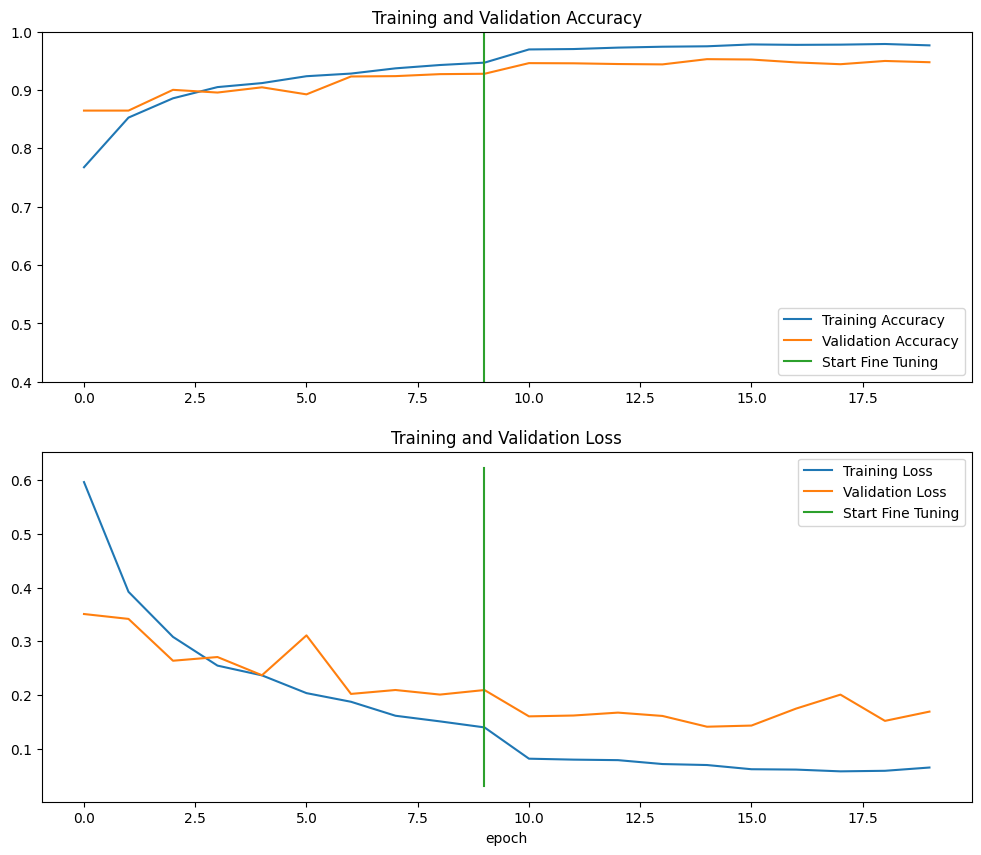

In [33]:
# Concatenate the initial training history with the fine-tuning history
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])  # set the y-axis limits
plt.plot([base_epochs - 1, base_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([base_epochs - 1, base_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()


In [34]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print("Test dataset evaluation")
results = model.evaluate(test_ds)
print(f"Loss: {results[0]}, Accuracy: {results[1]}")

# Get the true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

# Calculate accuracy, precision, recall, and f1-score
accuracy = accuracy_score(y_true, y_pred)

precision_micro_ft = precision_score(y_true, y_pred, average='micro')
recall_micro_ft = recall_score(y_true, y_pred, average='micro')
f1_micro_ft = f1_score(y_true, y_pred, average='micro')

precision_macro_ft = precision_score(y_true, y_pred, average='macro')
recall_macro_ft = recall_score(y_true, y_pred, average='macro')
f1_macro_ft = f1_score(y_true, y_pred, average='macro')

# Detailed classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)



Test dataset evaluation
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 839ms/step - accuracy: 0.9653 - loss: 0.1108
Loss: 0.11603577435016632, Accuracy: 0.9603545069694519
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2024-05-31 05:07:58.687053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
print(f"Micro Precision: {precision_micro_ft}")
print(f"Micro Recall: {recall_micro_ft}")
print(f"Micro F1-Score: {f1_micro_ft}")

print(f"Macro Precision: {precision_macro_ft}")
print(f"Macro Recall: {recall_macro_ft}")
print(f"Macro F1-Score: {f1_macro_ft}")

Micro Precision: 0.9598880597014925
Micro Recall: 0.9598880597014925
Micro F1-Score: 0.9598880597014925
Macro Precision: 0.9660786920725061
Macro Recall: 0.9598905949048279
Macro F1-Score: 0.962656036935752


In [36]:
print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,280,526 (96.44 MB)

 Trainable params: 567,428 (2.16 MB)

 Non-trainable params: 23,578,240 (89.94 MB)

 Optimizer params: 1,134,858 (4.33 MB)

None


In [37]:
total_params = model.count_params()

print(f"Total number of parameters: {total_params}")

Total number of parameters: 24145668


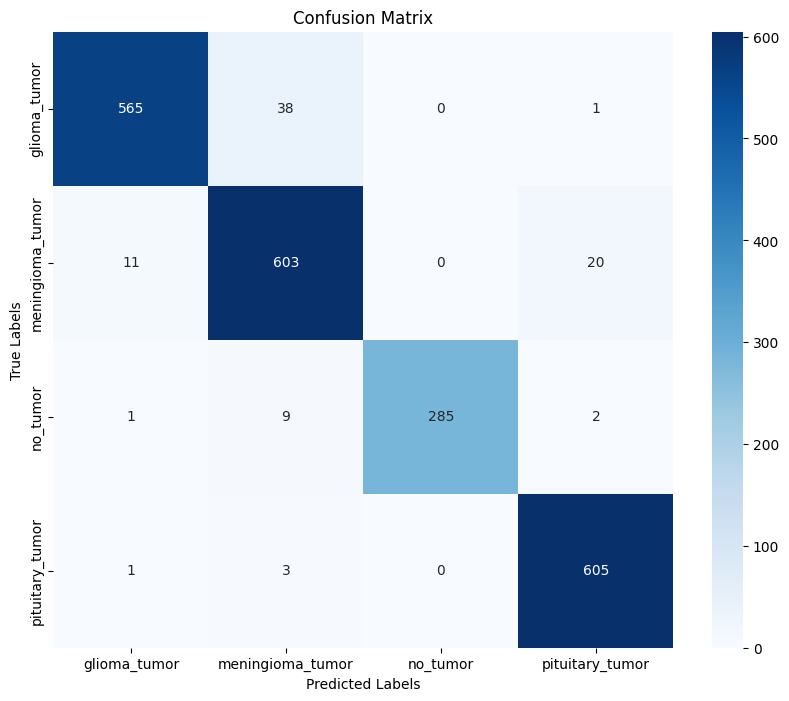

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


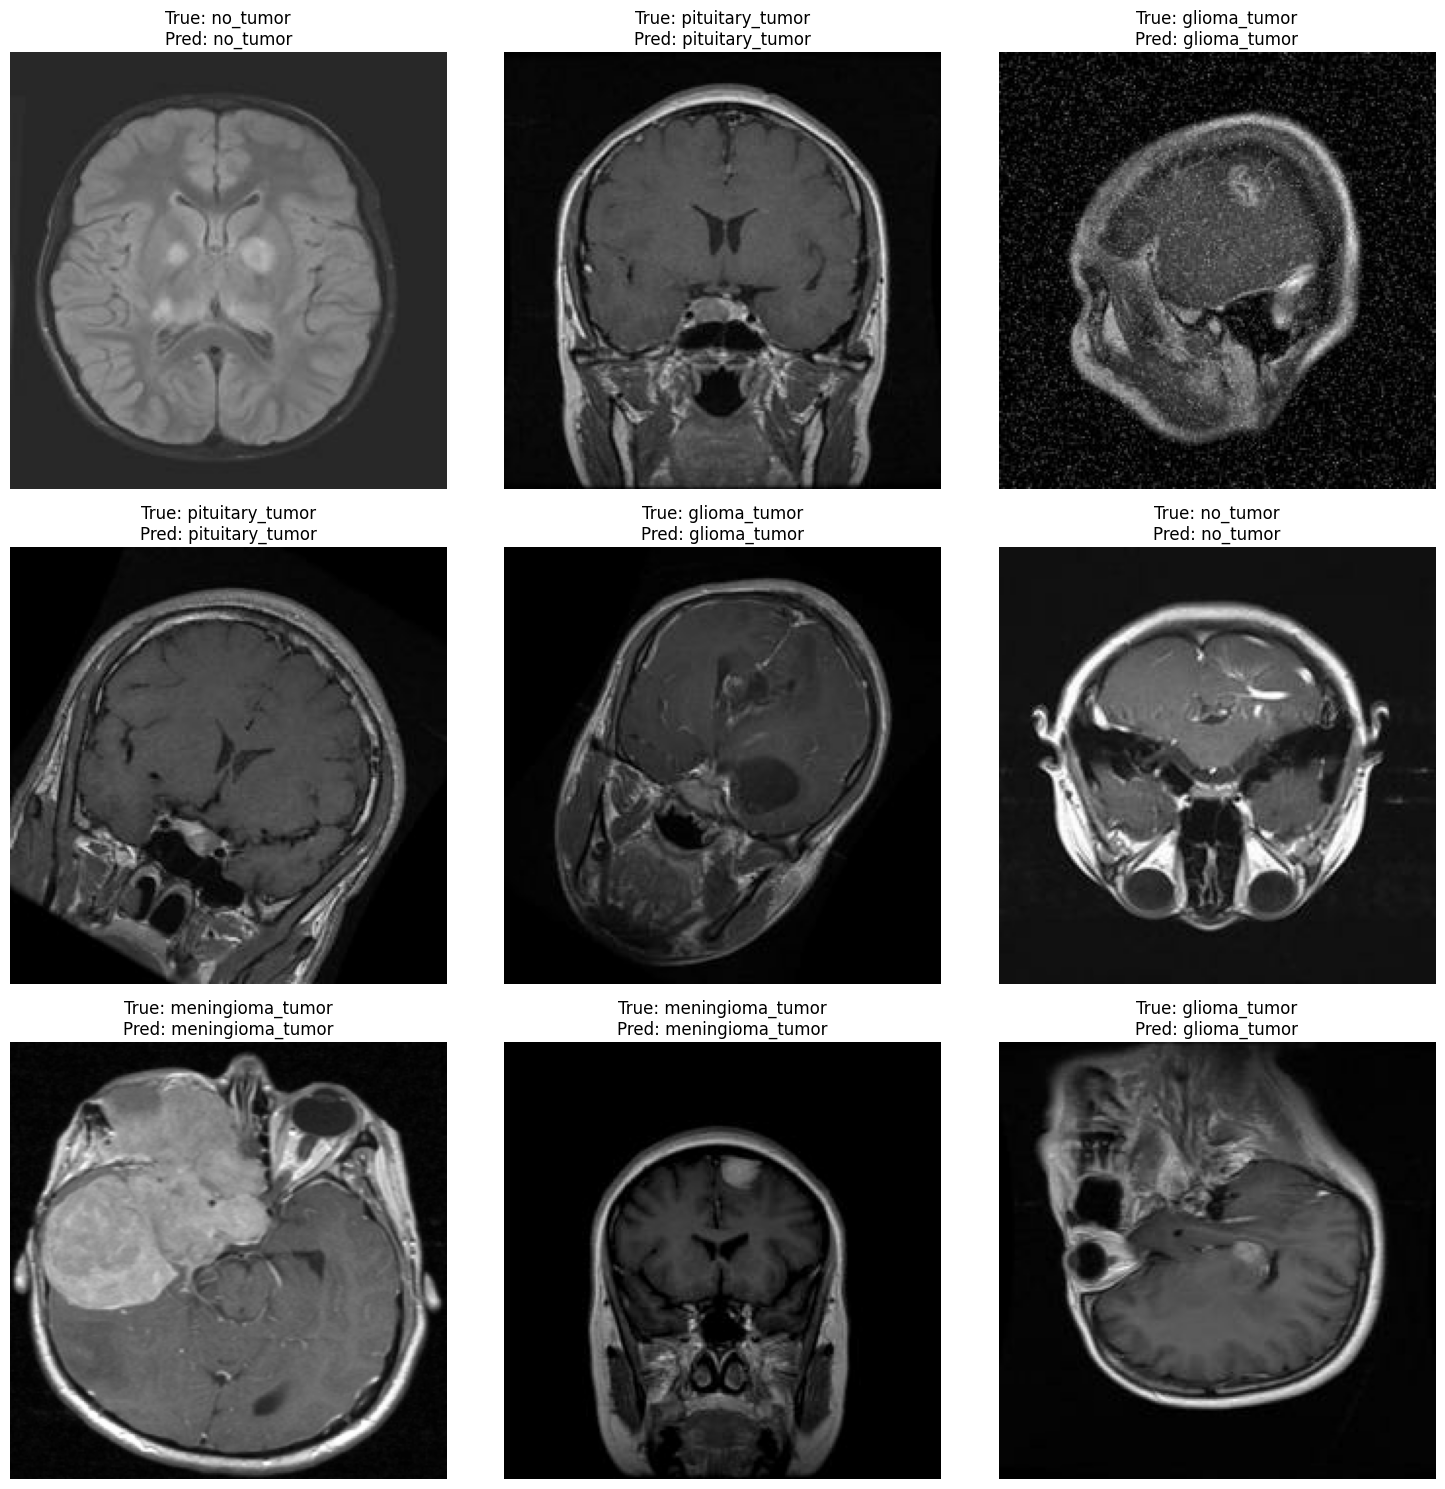

2024-05-31 05:08:00.502207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

def plot_images(images, labels, predictions):
    plt.figure(figsize=(15, 15))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[np.argmax(labels[i])]
        predicted_label = class_names[np.argmax(predictions[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
        plt.axis("off")
    plt.tight_layout()

for images, labels in test_ds.take(1): 
    predictions = model.predict(images)
    plot_images(images, labels, predictions)
    plt.show()


In [40]:
model.save('brain_classification.keras')

### Performance comparison
Following the fine-tuning process, the model's performance improved significantly. The accuracy rate increased from 93% to 96%. Furthermore, the micro F1-score increased from 0.931 to 0.960, and the macro F1-score improved from 0.935 to 0.963, indicating enhanced precision and recall across all classes.

In summary, the fine-tuning process effectively enhanced the model's performance without inducing overfitting, as evidenced by the consistent alignment of training and validation metrics throughout the process.

### User validation
I conducted user validation by sharing the project with colleagues who are medical students. The feedback was positive overall, indicating that the model performs well. However, it was observed that the model is prone to erroneous predictions when dealing with MRI images of inferior quality.